04 .Differential expression using DESeq2
========================================
 The analysis process includes three main steps, namely normalization, dispersion estimation and test for differential expression.

In [1]:
library(phyloseq)
library(ggplot2)
library(scales)
library(gridExtra)
suppressPackageStartupMessages(library(DESeq2))


In [3]:
#rds <- readRDS("../../../../../data/tmp/microbiome/quant/qiime2/silva/physeq_filtered.rds")


In [4]:
rds <- readRDS(snakemake@input[[1]])

In [19]:

df <- data.frame(as(sample_data(rds), "matrix"))
group <- factor(df[,snakemake@params$condition])
cat("Condition: ", snakemake@params$condition, "\n")
cat("Summary:\n")
print(summary(group))
if (!is.null(snakemake@params$ref_level)){
    cat("Setting", snakemake@params$ref_level, "as reference level", "\n")
    group <- relevel(group, ref=snakemake@params$ref_level)
    df[,"Sample_Group"] <- group
    sample_data(rds) <- df
}

batch <- NULL
if (!is.null(snakemake@params$batch)){
    print(cat("\nBatch factor given as: ", snakemake@params$batch, "\n"))
    batch <- factor(snakemake@params$batch)
    print(summary(batch))
    df[,snakemake@params$batch] <- batch
    sample_data(rds) <- df
}

subset <- NULL
if (!is.null(snakemake@params$subset)){
    if (grepl("::", snakemake@params$subset)){
        els <- unlist(strsplit(snakemake@params$subset, "::"))
        keep <- df[,els[1]] == els[2]
        cat("\nSample subset exracted from", els[1], "==", els[2], "\n\n")
    } else{
        subset <- unlist(strsplit(snakemake@params$subset, ","))
        keep <- sample_names(rds) %in% subset 
    }
    cat("We are now using", sum(keep), "samples")
    rds <- prune_samples(keep, rds)
    rds
}


Condition:  Sample_Group 
Summary:
     HC     PPI PPI_FGP 
     11       9      16 
Setting HC as reference level 

Sample subset exracted from Sample_Biosource == saft 

We are now using 36 samples

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 821 taxa and 36 samples ]
sample_data() Sample Data:       [ 36 samples by 3 sample variables ]
tax_table()   Taxonomy Table:    [ 821 taxa by 7 taxonomic ranks ]
phy_tree()    Phylogenetic Tree: [ 821 tips and 814 internal nodes ]
refseq()      DNAStringSet:      [ 821 reference sequences ]

In [ ]:
if (!is.null(snakemake@params$taxrank)){
    cat("Taxrank: ", snakemake@params$taxrank, "\n")
    if (require(speedyseq)){
        rds <- speedyseq::tax_glom(rds, taxrank=snakemake@params$taxrank)
    } else{
        rds <- tax_glom(rds, taxrank=snakemake@params$taxrank)
    } 
} else{
    cat("Taxrank: None, Data is not aggregated. Each feature is an ASV (specific sequence)", "\n")
}
rds

In [7]:

#if (!is.null(snakemake@params$independent_filtering)){
#    if (snakemake@params$independent_filtering == TRUE){
#        rds <- filter_taxa(rds, function(x) sum(x>0) > 10, TRUE)
#    }
#}



In [31]:
counts <- as(otu_table(rds), "matrix")
head(counts)
df <- data.frame(as(sample_data(rds), "matrix"))

,1_S,10_S,11_S,12_S,13_S,14_S,15_S,16_S,17_S,18_S,⋯,32_S,33_S,34_S,35_S,4_S,5_S,6_S,7_S,8_S,9_S
2391a4ac18f9382ac23703e10b46b520,0,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
b6181754e235bdbb1d792c568a85c2bd,0,0,0,0,0,0,0,0,0,0,⋯,0,0,0,13,0,0,0,63,0,0
cd8d1130789b70798033445d08af0c66,136,0,0,0,135,0,0,409,0,33,⋯,0,24,0,0,0,4,0,0,0,0
46d02aaa6e2c73022123854800837570,83,0,0,0,0,23,0,0,520,0,⋯,0,0,0,0,0,0,151,0,0,0
28729927cd4eeaab4bbfeeec472210d2,0,0,49,0,0,0,0,0,130,0,⋯,0,0,0,0,0,0,0,0,0,0
0db760974e0df82b58e34de1383602b5,0,0,0,0,0,0,0,0,0,0,⋯,0,0,67,0,0,0,0,0,0,0


In [24]:

fun_summary=function(x){
  out=c(quantile(x,c(0,0.25,0.5),type=1),mean(x),quantile(x,c(0.75,1),type=1))
  names(out)=c("Min.","1st Qu.","Median","Mean","3rd Qu.","Max.")
  return(round(out,0))
}
t(apply(counts, 2, fun_summary))

,Min.,1st Qu.,Median,Mean,3rd Qu.,Max.
1_S,0,0,0,107,0,15404
10_S,0,0,0,62,0,8837
11_S,0,0,0,88,0,14230
12_S,0,0,0,109,0,12891
13_S,0,0,0,112,0,37478
14_S,0,0,0,87,5,16023
15_S,0,0,0,94,6,29388
16_S,0,0,0,92,3,11394
17_S,0,0,0,86,0,9142
18_S,0,0,0,76,0,12798


In [40]:
 if (utils::packageVersion("ggplot2") >= "3.3.0") expand_scale <- expansion
barplotTotal <- function(counts, group, col=c("lightblue","orange","MediumVioletRed","SpringGreen"), outfile=TRUE){
  if (outfile) png(filename="figures/barplotTotal.png", width=min(3600, 1800+800*ncol(counts)/10), height=1800, res=300)
  d <- data.frame(tc=colSums(counts)/1e3, sample=factor(colnames(counts), colnames(counts)), group)
  print(ggplot(d, aes(x=.data$sample, y=.data$tc, fill=.data$group)) +
          geom_bar(stat="identity", show.legend=TRUE) +
          labs(fill="") +
          scale_fill_manual(values=col) +
          xlab("Samples") + 
          ylab("Total read count (thousands)") +
          scale_y_continuous(expand=expand_scale(mult=c(0.01, 0.05))) +
          ggtitle("Total read count per sample (million)") +
          theme(axis.text.x=element_text(angle=90, hjust=1, vjust=0.5)))
  if (outfile) dev.off()
}

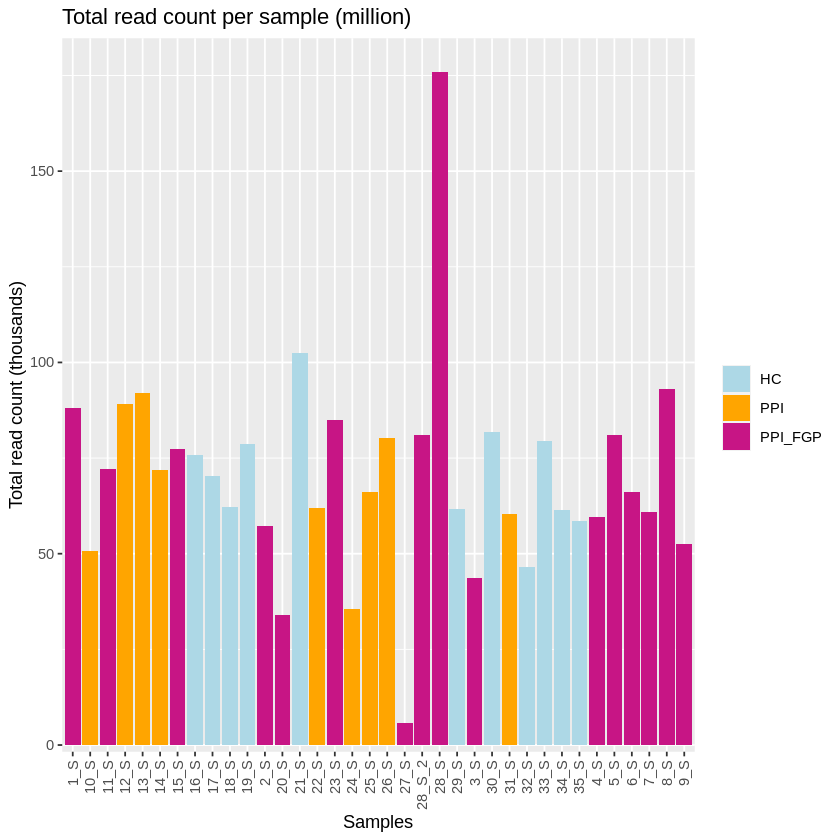

In [41]:
barplotTotal(counts, df$Sample_Group, outfile=FALSE)

In [48]:
gm_mean = function(x, na.rm=TRUE){
    exp(sum(log(x[x > 0]), na.rm=na.rm) / length(x))
}


In [49]:
dds = phyloseq_to_deseq2(rds, design=~Sample_Group)
geoMeans = apply(counts(dds), 1, gm_mean)
dds = estimateSizeFactors(dds, geoMeans=geoMeans)
de = DESeq(dds)



converting counts to integer mode

using pre-existing size factors

estimating dispersions

gene-wise dispersion estimates

mean-dispersion relationship

final dispersion estimates

fitting model and testing

-- replacing outliers and refitting for 471 genes
-- DESeq argument 'minReplicatesForReplace' = 7 
-- original counts are preserved in counts(dds)

estimating dispersions

fitting model and testing



In [64]:
countsBoxplots <- function(object, group, col = c("lightblue","orange","MediumVioletRed","SpringGreen"), outfile=TRUE){
  if (class(object)=="DESeqDataSet"){
    counts <- counts(object)
    #counts <- removeNull(counts)
    norm.counts <- counts(object, normalized=TRUE)
    #norm.counts <- removeNull(norm.counts)  
  } else{
    counts <- object$counts
    #counts <- removeNull(counts)
    tmm <- object$samples$norm.factors
    N <- colSums(object$counts)
    f <- tmm * N/mean(tmm * N)
    norm.counts <- scale(object$counts, center=FALSE, scale=f)
    #norm.counts <- removeNull(norm.counts)    
  }

  if (outfile) png(filename="figures/countsBoxplots.png", width=2*min(2200, 1800+800*ncol(norm.counts)/10), height=1800, res=300)
  d <- stack(as.data.frame(counts))
  d$group <- rep(group, each=nrow(counts))
  p1 <- ggplot(d) + 
    geom_boxplot(aes(x=.data$ind, y=.data$values+1, fill=.data$group), show.legend=TRUE) +
    labs(fill="") +
    scale_y_continuous(trans = log10_trans(),
                       breaks = trans_breaks("log10", function(x) 10^x),
                       labels = trans_format("log10", math_format(~10^.x))) +
    scale_fill_manual(values=col) +
    xlab("Samples") +
    ylab("Raw counts") +
    ggtitle("Raw counts distribution") +
    theme(axis.text.x=element_text(angle=90, hjust=1, vjust=0.5))
  
  d <- stack(as.data.frame(norm.counts))
  d$group <- rep(group, each=nrow(norm.counts))
  p2 <- ggplot(d) + 
    geom_boxplot(aes(x=.data$ind, y=.data$values+1, fill=.data$group), show.legend=TRUE) +
    labs(fill="") +
    scale_y_continuous(trans = log10_trans(),
                       breaks = trans_breaks("log10", function(x) 10^x),
                       labels = trans_format("log10", math_format(~10^.x))) +
    scale_fill_manual(values=col) +
    xlab("Samples") +
    ylab("Normalized counts") +
    ggtitle("Normalized counts distribution") +
    theme(axis.text.x=element_text(angle=90, hjust=1, vjust=0.5))
  
  grid.arrange(p1, p2, nrow=2, ncol=1)
  if (outfile) dev.off()
    
}

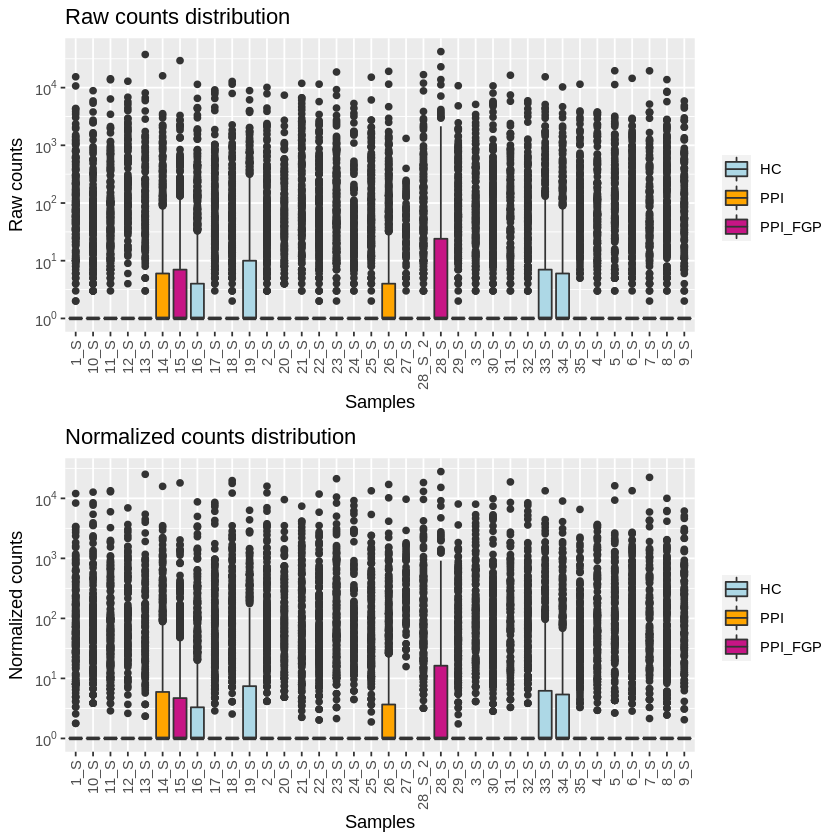

In [65]:
countsBoxplots(de, df$Sample_Group, outfile=FALSE)

In [71]:
densityPlot <- function(counts, group, col=c("lightblue","orange","MediumVioletRed","SpringGreen"), outfile=TRUE){
  if (outfile) png(filename="figures/densplot.png", width=2000, height=1800, res=300)
    #counts <- removeNull(counts)
    d <- stack(data.frame(counts))
    d$group <- rep(group, each=nrow(counts))
    print(ggplot(d, aes(x=.data$values+1)) +
            stat_density(aes(group=.data$ind, color=.data$group), position="identity", geom="line", show.legend=TRUE) +
            scale_x_continuous(trans = log10_trans(),
                               breaks = trans_breaks("log10", function(x) 10^x),
                               labels = trans_format("log10", math_format(~10^.x))) +
            labs(color="") +
            scale_colour_manual(values=col) +
            xlab("Raw counts") +
            ylab("Density") +
            ggtitle("Density of counts distribution"))
  if (outfile) dev.off()
}

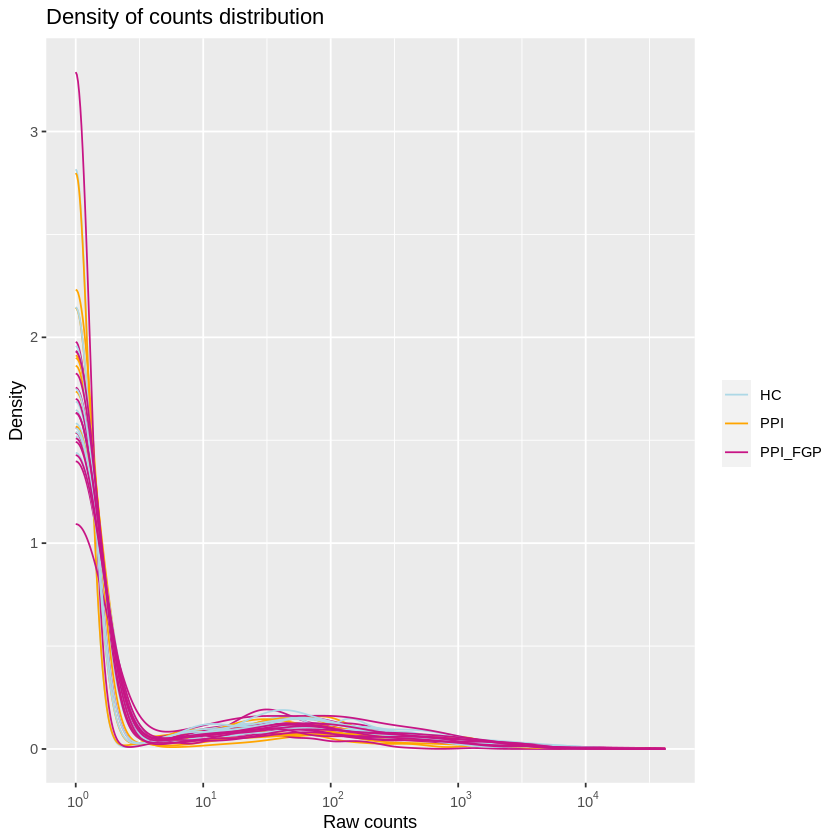

In [73]:
densityPlot(counts, df$Sample_Group, outfile=FALSE)

In [106]:
majSequences <- function(rds, n=3, group, taxrank="Species", col=c("lightblue","orange","MediumVioletRed","SpringGreen"), outfile=TRUE){
  counts <- as(otu_table(rds), "matrix")
  seqnames <- apply(counts, 2, function(x){x <- sort(x, decreasing=TRUE); names(x)[1:n]})
  seqnames <- unique(unlist(as.character(seqnames)))

  sum <- apply(counts,2,sum)
  counts <- counts[seqnames,]
  sum <- matrix(sum,nrow(counts),ncol(counts),byrow=TRUE)
  p <- round(100*counts/sum,digits=3)

  if (outfile) png(filename="figures/majSeq.png",width=min(3600,1800+800*ncol(counts)/10),height=1800,res=300)
    maj <- apply(p, 2, max)
    seqname <- rownames(p)[apply(p, 2, which.max)]
    TAX <- data.frame(as(tax_table(rds), "matrix"))[seqname,]
    taxname <- as.character(TAX[,taxrank])
    taxname[is.na(taxname)] <- as.character(TAX[is.na(taxname),"Genus"])
    d <- data.frame(maj=maj, sample=factor(names(maj), levels=names(maj)), group, seqname=seqname)
    print(ggplot(d, aes(x=.data$sample, y=.data$maj, fill=.data$group)) +
            geom_bar(stat="identity", show.legend=TRUE) +
            labs(fill="") +
            scale_fill_manual(values=col) +
            xlab("Samples") + 
            ylab("Percentage of reads") +
            scale_y_continuous(expand=expand_scale(mult=c(0.01, 0.05))) +
            ggtitle("Percentage of reads from most expressed sequence") +
            theme(axis.text.x=element_text(angle=90, hjust=1, vjust=0.5)) +
            geom_text(aes(y=0.8*maj, label=taxname), color="black", size=2.5, angle=90, fontface="bold"))
  if (outfile) dev.off()
  
  return(invisible(p))
}

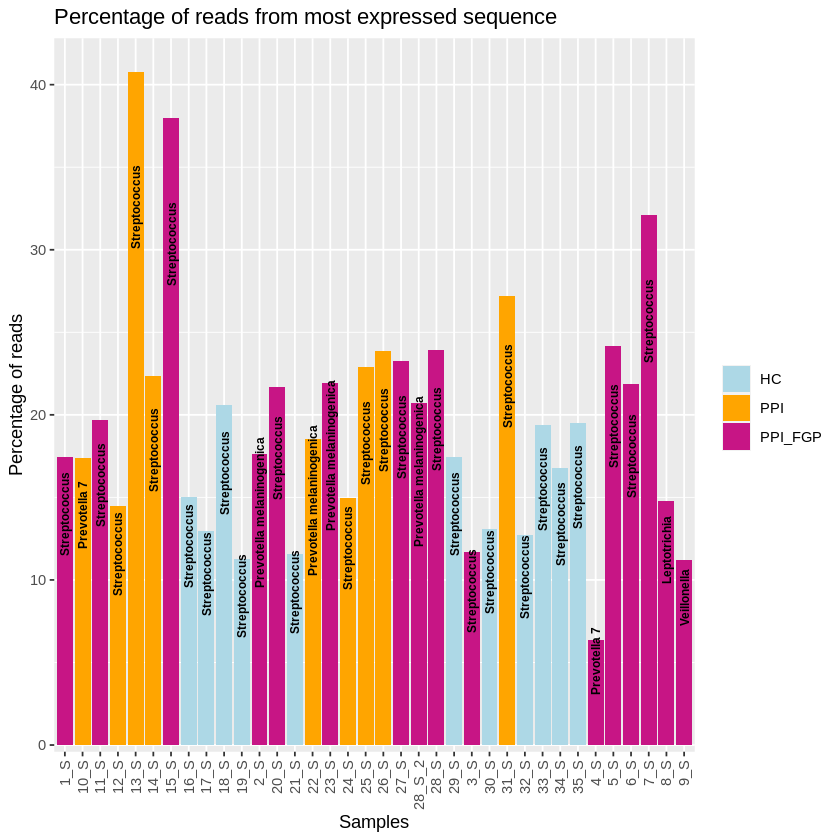

In [107]:
majSequences(rds, n=1, df$Sample_Group, outfile=FALSE)

In [108]:
dispersionsPlot <- function(dds, outfile=TRUE){
  if (outfile) png(filename="figures/dispersionsPlot.png", width=3600, height=1800, res=300)
	
  # dispersions plot
  d <- as.data.frame(mcols(dds)[,c("baseMean", "dispGeneEst", "dispFit", "dispersion")])
  d <- d[which(d$baseMean > 0),]
  d <- data.frame(baseMean=rep(d$baseMean, 3),
                  value=c(d$dispGeneEst, d$dispersion, d$dispFit),
                  variable=factor(rep(c("dispGeneEst", "dispersion", "dispFit"), each=nrow(d)),
                                  levels=c("dispGeneEst", "dispersion", "dispFit")))
  p1 <- ggplot(d, aes(x=.data$baseMean, y=.data$value, colour=.data$variable)) + 
    geom_point(size=0.1) +
    scale_x_continuous(trans = log10_trans(),
                       breaks = trans_breaks("log10", function(x) 10^x),
                       labels = trans_format("log10", math_format())) +
    scale_y_continuous(trans = log10_trans(),
                       breaks = trans_breaks("log10", function(x) 10^x),
                       labels = trans_format("log10", math_format())) +
    ylab("Dispersion") + 
    xlab("Mean of normalized counts") +
    scale_colour_manual(
      values=c("Black", "#377eb8", "#e41a1c"),
      breaks=c("dispGeneEst", "dispersion", "dispFit"),
      labels=c("Estimate", "Final", "Fit"),
      name="") +
    guides(colour = guide_legend(override.aes = list(size=2))) +
    ggtitle("Dispersions")
  
  # diagnostic of log normality
  disp <- mcols(dds)$dispGeneEst
  disp <- disp[!is.na(disp)]
  disp <- disp[disp>1e-8]
  disp <- log(disp)
  mean.disp <- mean(disp,na.rm=TRUE)
  sd.disp <- sd(disp,na.rm=TRUE)
  d <- data.frame(disp)
  p2 <- ggplot(data=d, aes(x=.data$disp)) +
    geom_histogram(bins=80, aes(y=.data$..density..)) +
    scale_y_continuous(expand=expand_scale(mult=c(0.01, 0.05))) +
    xlab("Feature dispersion estimate") +
    ylab("Density") +
    ggtitle("log-normality dispersion diagnostic") +
    stat_function(fun = dnorm, args = list(mean = mean.disp, sd = sd.disp))
  
  grid.arrange(p1, p2, layout_matrix=matrix(c(1, 1, 1, 1, 1, 2, 2, 2, 2), nrow=1))
  
  if (outfile) dev.off()
}

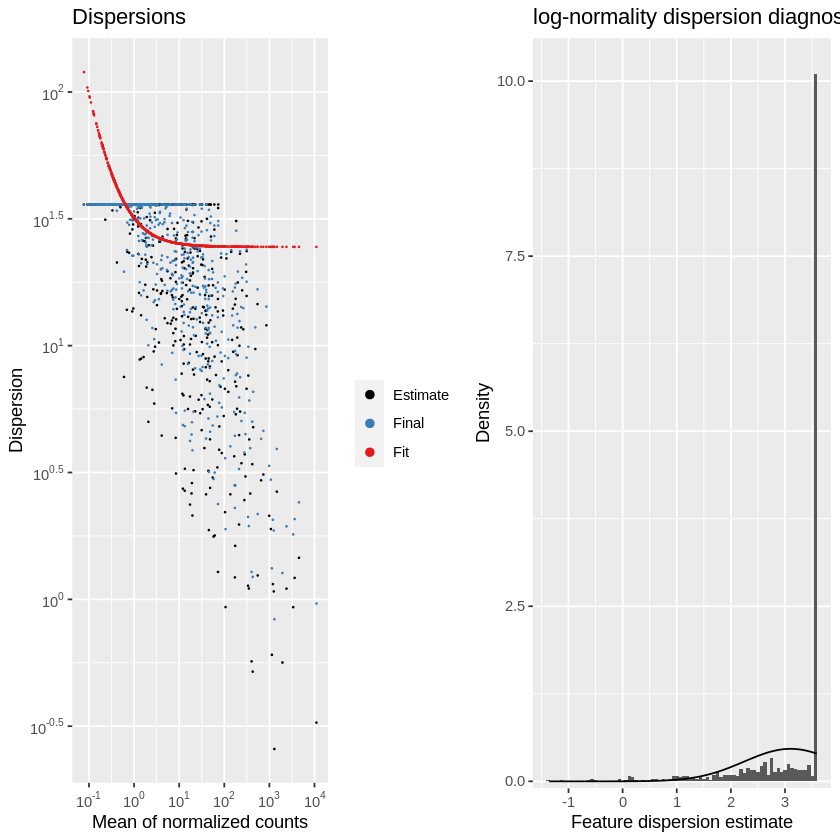

In [109]:
dispersionsPlot(de, outfile=FALSE)

In [111]:
CONTRASTS <- list()
df <- colData(de)
condition <- df[,"Sample_Group"]

if (snakemake@params$test == "ALLvsREF"){
    ref <- snakemake@params$ref_level
    for (test in levels(condition)){
        if (test != ref) CONTRASTS[[paste0(test, "__vs__", ref)]] <- c(snakemake@params$condition, test, ref)
        }
    
} else{
    for (comp in combn(nlevels(condition), 2, simplify=FALSE)){
        ref <- levels(condition)[comp[1]]
        test <- levels(condition)[comp[2]]
        CONTRASTS[[paste0(test, "__vs__", ref)]] <- c(snakemake@params$condition, test, ref)
        }
    }


In [112]:
nDiffTotal <- function(complete, alpha=0.05){
  nDiffTotal <- matrix(NA,ncol=4,nrow=length(complete),dimnames=list(names(complete),c("Test vs Ref", "# down","# up","# total")))
  for (name in names(complete)){
    complete.name <- complete[[name]]
    if (!is.null(complete.name$betaConv)){
    nDiffTotal[name,2:3]=c(nrow(complete.name[which(complete.name$padj <= alpha & complete.name$betaConv & complete.name$log2FoldChange<=0),]),
                             nrow(complete.name[which(complete.name$padj <= alpha & complete.name$betaConv & complete.name$log2FoldChange>=0),]))
    } else{
      nDiffTotal[name,2:3]=c(nrow(complete.name[which(complete.name$padj <= alpha & complete.name$log2FoldChange<=0),]),
                             nrow(complete.name[which(complete.name$padj <= alpha & complete.name$log2FoldChange>=0),]))
    }
  }
  nDiffTotal[,4] <- nDiffTotal[,2] + nDiffTotal[,3]
  nDiffTotal[,1] <- gsub("_"," ",rownames(nDiffTotal))
  rownames(nDiffTotal) <- NULL
  return(nDiffTotal)
}

In [122]:
complete <- list()
for (contrast in names(CONTRASTS)){
    res = results(de, cooksCutoff=FALSE, contrast=CONTRASTS[[contrast]], alpha=snakemake@params$alpha)
    tab = cbind(as(res, "data.frame"), as(tax_table(rds)[rownames(res), ], "matrix"))
    tab = tab[order(tab$padj, na.last=TRUE), ]
    fn <- file.path(snakemake@output[[1]], paste0(snakemake@params$taxrank, "_", contrast, ".txt"))
    dir.create(snakemake@output[[1]], showWarnings=FALSE, recursive=TRUE)
    write.table(tab, file=fn, sep="\t")
    complete[[contrast]] <- tab
}

In [123]:
nDiffTotal(complete)

Test vs Ref,# down,# up,# total
PPI vs HC,19,11,30
PPI FGP vs HC,7,14,21
PPI FGP vs PPI,9,24,33


In [124]:
rawpHist <- function(complete, outfile=TRUE){
  ncol <- min(2, length(complete))
  nrow <- ceiling(length(complete)/ncol)
  if (outfile) png(filename="figures/rawpHist.png", width=cairoSizeWrapper(1800*ncol), height=cairoSizeWrapper(1800*nrow), res=300)
  p <- list()
  for (name in names(complete)){
    complete.name <- complete[[name]]
    complete.name <- complete.name[which(!is.na(complete.name$pvalue)),]
    p[[name]] <- ggplot(data=complete.name, aes(x=.data$pvalue)) +
      geom_histogram(binwidth=0.02) +
      scale_y_continuous(expand=expand_scale(mult=c(0.01, 0.05))) +
      xlab("Raw p-value") +
      ylab("Frequency") +
      ggtitle(paste0("Distribution of raw p-values - ", gsub("_"," ",name)))
  }
  tmpfun <- function(...) grid.arrange(..., nrow=nrow, ncol=ncol)
  do.call(tmpfun, p)
  if (outfile) dev.off()
}

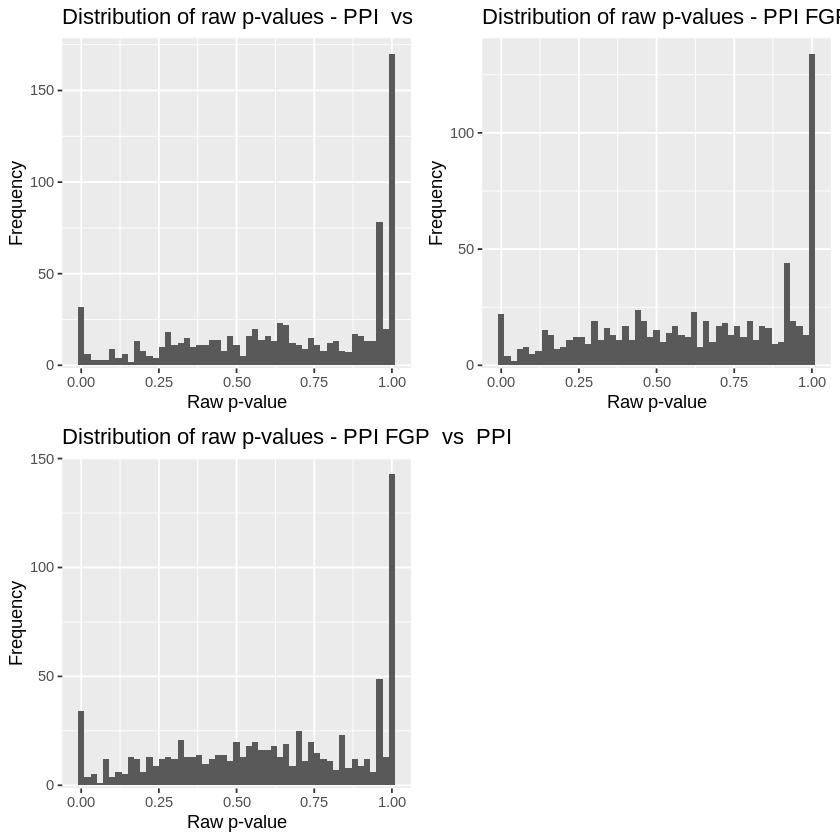

In [125]:
rawpHist(complete, outfile=FALSE)

In [128]:
volcanoPlot <- function(complete, alpha=0.05, outfile=TRUE, padjlim=NULL){
  ncol <- min(2, length(complete))
  nrow <- ceiling(length(complete)/ncol)
  if (outfile) png(filename="figures/volcanoPlot.png", width=cairoSizeWrapper(1800*ncol), height=cairoSizeWrapper(1800*nrow), res=300)
  p <- list()
  for (name in names(complete)){
    complete.name <- complete[[name]]
    complete.name$padj[which(complete.name$padj==0)] <- .Machine$double.xmin
    complete.name <- complete.name[which(!is.na(complete.name$padj)),]
    complete.name$DE <- factor(ifelse(complete.name$padj <= alpha, "yes", "no"), levels=c("no", "yes"))
    if (is.null(padjlim)) padjlim.name <- quantile(complete.name$padj, probs=0.01, na.rm=TRUE) else padjlim.name <- padjlim
    complete.name$outfield <- factor(ifelse(complete.name$padj < padjlim.name, "top", "in"), levels=c("in", "top"))
    complete.name$padj[which(complete.name$padj < padjlim.name)] <- padjlim.name
    reverselog_trans <- function(base = exp(1)) {
      trans <- function(x) -log(x, base)
      inv <- function(x) base^(-x)
      trans_new(paste0("reverselog-", format(base)), trans, inv,
                log_breaks(base = base),
                domain = c(.Machine$double.xmin, Inf))
    }
    p[[name]] <- ggplot(data=complete.name, 
                        aes(x=.data$log2FoldChange, y=.data$padj, color=.data$DE, shape=.data$outfield)) +
      geom_point(show.legend=FALSE, alpha=0.5) +
      scale_y_continuous(trans = reverselog_trans(10),
                         breaks = trans_breaks("log10", function(x) 10^x),
                         labels = trans_format("log10", math_format(~10^.x))) +
      scale_colour_manual(values=c("no"="black", "yes"="red"), drop=FALSE) +
      scale_shape_manual(values=c("in"=16, "top"=17), drop=FALSE) +
      xlab(expression(log[2]~fold~change)) +
      ylab("Adjusted P-value") +
      ggtitle(paste0("Volcano plot - ", gsub("_", " ", name)))
  }
  tmpfun <- function(...) grid.arrange(..., nrow=nrow, ncol=ncol)
  do.call(tmpfun, p)
  if (outfile) dev.off()
}
                         

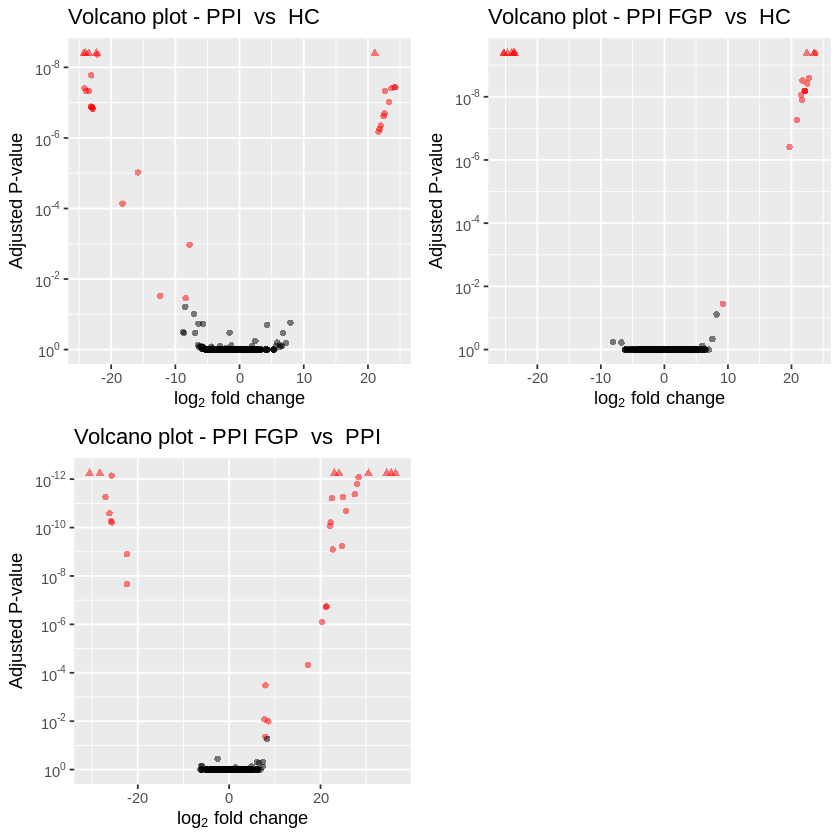

In [127]:
volcanoPlot(complete, outfile=FALSE)

In [129]:
MAPlot <- function(complete, alpha=0.05, outfile=TRUE, log2FClim=NULL){
  ncol <- min(2, length(complete))
  nrow <- ceiling(length(complete)/ncol)
  if (outfile) png(filename="figures/MAPlot.png", width=cairoSizeWrapper(1800*ncol), height=cairoSizeWrapper(1800*nrow), res=300)
  p <- list()
  for (name in names(complete)){
    complete.name <- complete[[name]]
    complete.name <- complete.name[which(complete.name$baseMean>0),]
    complete.name$padj <- ifelse(is.na(complete.name$padj), 1, complete.name$padj)
    complete.name$DE <- factor(ifelse(complete.name$padj <= alpha, "yes", "no"), levels=c("no", "yes"))
    py <- complete.name$log2FoldChange
    if (is.null(log2FClim)) ymax <- quantile(abs(py[is.finite(py)]), probs=0.99) else ymax <- log2FClim
    complete.name$log2FoldChange[which(py > ymax)] <- ymax
    complete.name$log2FoldChange[which(py < -ymax)] <- -ymax
    complete.name$outfield <- factor(ifelse(py > ymax, "top", ifelse(py < -ymax, "bottom", "in")), 
                                     levels=c("bottom", "in", "top"))
    p[[name]] <- ggplot(data=complete.name, 
                        aes(x=.data$baseMean, y=.data$log2FoldChange, color=.data$DE, fill=.data$DE, shape=.data$outfield)) +
      scale_x_continuous(trans = log10_trans(),
                         breaks = trans_breaks("log10", function(x) 10^x),
                         labels = trans_format("log10", math_format(~10^.x))) +
      geom_point(show.legend=FALSE, alpha=0.5, size=0.8) +
      scale_colour_manual(values=c("no"="black", "yes"="red"), drop=FALSE) +
      scale_shape_manual(values=c("bottom"=25, "in"=21, "top"=24), drop=FALSE) +
      scale_fill_manual(values=c("no"="black", "yes"="red"), drop=FALSE) +
      scale_y_continuous(expand=expand_scale(mult=c(0.03, 0.03))) +
      xlab("Mean of normalized counts") +
      ylab(expression(log[2]~fold~change)) +
      ggtitle(paste0("MA-plot - ", gsub("_"," ",name)))
  }
  tmpfun <- function(...) grid.arrange(..., nrow=nrow, ncol=ncol)
  do.call(tmpfun, p)
  if (outfile) dev.off()
}

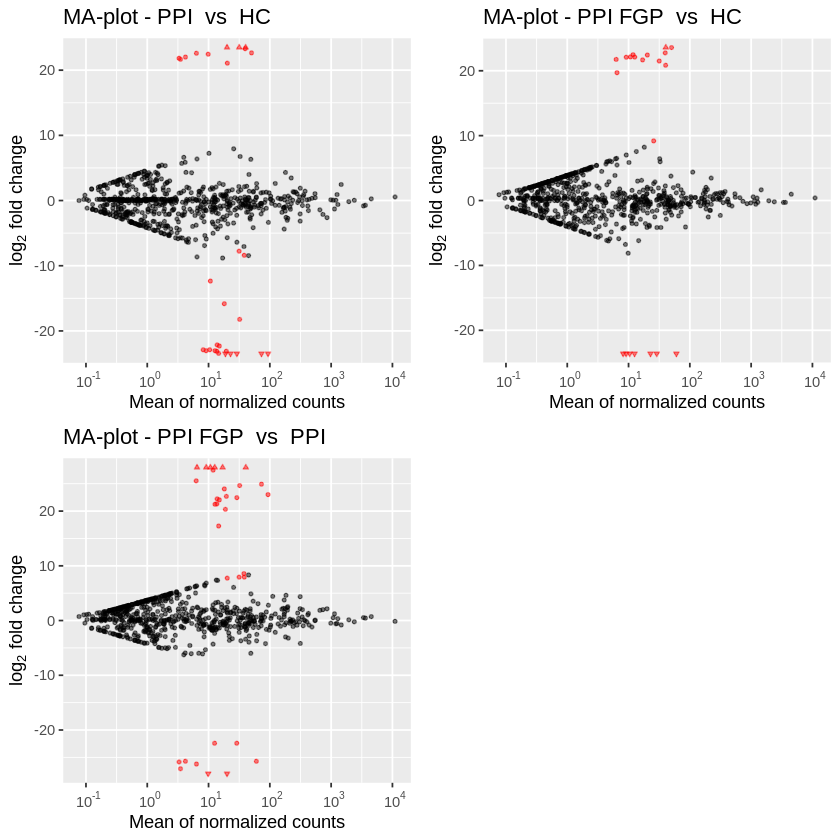

In [131]:
MAPlot(complete, outfile=FALSE)

In [4]:
all_sign <- c()
for (name in names(complete)){
    complete.name <- complete[[name]]
    complete.name$padj <- ifelse(is.na(complete.name$padj), 1, complete.name$padj)
    ids <- rownames(complete.name)[complete.name$padj <= snakemake@params$alpha]
all_sign <- c(all_sign, ids)
    }
all_sign <- unique(all_sign)


ERROR: Error in eval(expr, envir, enclos): object 'complete' not found


In [5]:

if (length(all_sign) > 1){
    gpac <- prune_taxa(all_sign, rds)
    gpac <- filter_taxa(gpac, function(x) sum(x>0) > 1, TRUE)
    gpac <- prune_samples(sample_sums(gpac) > 1, gpac)
    plot_heatmap(gpac, "NMDS", "bray", snakemake@params$condition, snakemake@params$taxrank, low="#66CCFF", high="#000033", na.value="white")
}


Hetmap of features found significant in analysis